<a href="https://colab.research.google.com/github/Mtlukasik/Exploration/blob/main/OOD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

- Import additional libraries of your choice.

Although you are expected to demonstrate understanding of ML/DS/statistics tools, a particular choice of libraries and frameworks will not affect evaluation of the solution.

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import keras
import sklearn
import hashlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Input, Dense, Reshape
# Import additional libraries of your choice

# Unity Data Science quiz

At Unity, we develop deep learning models for real-time ads bidding ([OpenRTB](https://www.iab.com/guidelines/openrtb/)) at various ad
exchanges. To bid for an ad impression, we estimate the optimal bid value using predicted
install probability of campaign together with several other factors e.g. cost per install.

In this homework, your task is to **train a model to predict *install probabilities* for ad impressions included in
the test data**. In the production environment, the model predictions are used for deriving the optimial bids for available ad campaigns.  The best ad campaign will be shown to the user. Overestimation of install probabilities will lead to unnecessarily high bids and monetary losses, while underestimation of install probabilities will lead to unnecessarily low bids and loss of opportunities for Unity to win ad impressions. Therefore, it is important for the model predictions to be as accurate as possible.

## Instructions

- Complete the homework using Python and libraries of your choice.
- Follow the instructions in this notebook.
- Keep the code clean and organized.

## Evaluation

We focus our evaluation on technical proficiency, analytical skills, problem solving, creative thinking as well as ability to communicate clearly. In particular, we will evaluate:
- understanding of the problem (e.g. does a delivered solution meet the specification of the task)
- quality of discussion and brevity of the report (e.g. comments in this notebook)
- quality of EDA
- feature handling & preprocessing
- modeling approach
- model validation and evaluation

We will separately evaluate the predicted test set install probabilities (see below). Although considered as part of the evaluation, the final performance is not the key factor and shall not dominate over the above dimensions.

## Data description

- ```id```: impression id
- ```timestamp```: time of the event in UTC ```
 all installs happened  long ago this game is probably old```
- ```campaignId```: id of the advertising campaign (the game being advertised)
- ```platform```: device platform
- ```softwareVersion```: OS version of the device
- ```country```: country of user
- ```sourceGameId```: id of the publishing game (the game being played)
- ```startCount```: how many times the user has started (any) campaigns
- ```viewCount```: how many times the user has viewed (any) campaigns
- ```clickCount```: how many times the user has clicked (any) campaigns
- ```installCount```: how many times the user has installed games from this ad network
- ```lastStart```: last time the user started any campaign
- ```startCount1d```: how many times the user has started (any) campaigns within the last 24 hours
- ```startCount7d```: how many times the user has started (any) campaigns within the last 7 days
- ```connectionType```: internet connection type
- ```deviceType```: device model
- ```install```: binary indicator if install was observed (install=1) or not (install=0) after impression

## Submission

- This Jupyter notebook
- A CSV file containing the predicted install probabilities of ad impressions in the test data. The file should have the following columns:
    - ```id```: ID of ad impression in the test data
    - ```install_proba```: Predicted install probability of ad impression


# Analysis
by Mateusz Łukasik
 - start date: 2.05
 - submitted: 6.05

## Load and prepare data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/training_data.csv", sep=";", parse_dates=True)
train_df = train_df[~train_df['install'].isna()]#inputing install label is classification so there is no use in it
train_df = train_df[~train_df['lastStart'].isna()]
train_df['lastStart'] = pd.to_datetime(train_df['lastStart'])
train_df = train_df.sort_values(by=['timestamp']).reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_df.columns

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'deviceType', 'install'],
      dtype='object')

In [5]:
import pandas as pd

# Ensure 'timestamp' is in datetime format
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Group the DataFrame by hour
daily_groups = train_df.groupby(pd.Grouper(key='timestamp', freq='D'))

# Initialize a list to hold the sub-DataFrames
daily_dfs = []

# Iterate over each group and add the sub-DataFrame to the list
for _, group in daily_groups:
    if not group.empty:  # Check if the group is not empty
        daily_dfs.append(group)
[i.shape for i in daily_dfs]

[(315482, 17),
 (313690, 17),
 (306825, 17),
 (281678, 17),
 (232467, 17),
 (225278, 17),
 (189106, 17),
 (201060, 17),
 (214095, 17),
 (211327, 17),
 (223277, 17),
 (257102, 17),
 (272655, 17),
 (219667, 17)]

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.utils import resample

class DataPreprocessor:
    def __init__(self, numerical_columns, target_column):
        """
        Initialize the preprocessor with the list of numerical columns
        to keep and convert to floats, and the name of the target column for undersampling.
        """
        self.numerical_columns = numerical_columns
        self.target_column = target_column

    def preprocess_(self,df):
        # Ensure the target column is included for processing
        if self.target_column in df.columns:
            columns = self.numerical_columns + [self.target_column]
        else:
            columns = self.numerical_columns

        processed_df = df[columns].copy()

        # Convert numerical columns to float dtype
        for col in self.numerical_columns:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').astype(float)
        return processed_df

    def preprocess_train(self, df):
        self.processed_df = self.preprocess_(df)

        # Calculate label counts to determine majority/minority
        label_counts = self.processed_df[self.target_column].value_counts()
        # Identify majority and minority labels based on counts
        majority_label = label_counts.idxmax()
        minority_label = label_counts.idxmin()

        # Separate majority and minority classes
        self.df_majority = self.processed_df[self.processed_df[self.target_column] == majority_label]
        self.df_minority = self.processed_df[self.processed_df[self.target_column] == minority_label]

        # Calculate the length ratio for informational purposes (optional)
        self.len_ratio = len(self.df_majority) / (len(self.df_majority) + len(self.df_minority))

        # Downsample the majority class to match minority class size
        df_majority_downsampled = resample(self.df_majority,
                                          replace=False,    # sample without replacement
                                          n_samples=len(self.df_minority),  # to match minority class size
                                          random_state=123) # reproducible results

        # Combine minority class with downsampled majority class
        self.balanced_df = pd.concat([self.df_minority, df_majority_downsampled])

        # Optionally, you might want to return the balanced DataFrame
        return self.balanced_df

class ConversionModel:

    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)
        self.target_column = 'install'

    def _build_model(self, input_shape):
        # Define a simple Sequential model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
            keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, epochs=30, validation_split=0.2):
        self.model.fit(X, y, epochs=epochs, validation_split=validation_split)

    def predict(self, X):
        return self.model.predict(X)

class OODModel:

    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)
        self.target_column = 'OOD'

    def _build_model(self, input_shape):
        # Define a simple Sequential model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
            keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, epochs=30, validation_split=0.2):
        self.model.fit(X, y, epochs=epochs, validation_split=validation_split)

    def predict(self, X):
        return self.model.predict(X)

class Postprocessor:
    def __init__(self, model, adjusted_threshold):
        self.model = model
        self.adjusted_threshold = adjusted_threshold
        print(self.adjusted_threshold)
    def predict(self, X):
        # Get the model's prediction probabilities
        predictions = self.model.predict(X)

        # Apply the adjusted threshold to these probabilities to get binary predictions
        binary_predictions = (predictions > self.adjusted_threshold*0.8).astype(int)
        return binary_predictions

class Valuator:
  def __init__(self,preprocessor,model,postprocessor,adjusted_threshold):
    #TODO: implement adjusted_threshold here
    self.preprocessor=preprocessor
    self.model = model
    self.postprocessor = postprocessor
  def predict(self, data):
      preprocessed_data = self.preprocessor.preprocess_(data)
      # Drop the target_column only if it exists in the DataFrame
      if self.model.target_column in preprocessed_data.columns:
          preprocessed_data = preprocessed_data.drop(columns=[self.model.target_column])
      return self.postprocessor.predict(preprocessed_data)

  def prob(self, data):
      preprocessed_data = self.preprocessor.preprocess_(data)
      # Drop the target_column only if it exists in the DataFrame
      if self.model.target_column in preprocessed_data.columns:
          preprocessed_data = preprocessed_data.drop(columns=[self.model.target_column])
      return self.postprocessor.model.predict(preprocessed_data)


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
numerical_columns = ['startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d']

def given_data_create_valuator(daily_df):
  target_column = 'install'  # Assuming 'install' is your target column

  # Initialize the preprocessor
  preprocessor = DataPreprocessor(numerical_columns=numerical_columns, target_column=target_column)
  preprocessor.preprocess_train(daily_df)
  # Preprocess your DataFrame
  X = preprocessor.balanced_df.drop(columns=[target_column])
  y = preprocessor.balanced_df[target_column]
  # Convert the target to a numeric type, if it's not already
  y = pd.to_numeric(y, errors='coerce')
  input_shape = X.shape[1]
  # Initialize and train the model
  my_model = ConversionModel(input_shape)
  my_model.fit(X, y)
  postprocessor = Postprocessor(my_model,preprocessor.len_ratio)
  return Valuator(preprocessor,my_model,postprocessor,preprocessor.len_ratio)


def from_valuator_create_ood(which_data_aquired, new_valuator_data, old_training_data, old_unseen_data):
  target_column = 'OOD'

  if not isinstance(old_unseen_data, pd.DataFrame) or old_unseen_data.empty:
      old_unseen_data = pd.DataFrame(columns=new_valuator_data.columns)

  new_train_data = pd.concat([old_training_data, new_valuator_data[which_data_aquired.astype(bool)]])
  new_unseen_data = pd.concat([old_unseen_data, new_valuator_data[~which_data_aquired.astype(bool)]])
  print(f"new_train_data.shape: {new_train_data.shape},new_unseen_data.shape: {new_unseen_data.shape}")
  unseen_data_ = new_unseen_data.drop(columns=['install'])
  train_data_ = new_train_data.drop(columns=['install'])

  # Add OOD column
  unseen_data_['OOD'] = 0
  train_data_['OOD'] = 1

  ood_train_data = pd.concat([train_data_, unseen_data_], ignore_index=True)

  preprocessor_OOD = DataPreprocessor(numerical_columns=numerical_columns, target_column=target_column)
  preprocessor_OOD.preprocess_train(ood_train_data)

  # Preprocess your DataFrame
  X = preprocessor_OOD.balanced_df.drop(columns=[target_column])
  y = preprocessor_OOD.balanced_df[target_column]

  # Convert the target to a numeric type, if it's not already
  y = pd.to_numeric(y, errors='coerce')
  input_shape = X.shape[1]

  # Initialize and train the model
  OOD_model = OODModel(input_shape)
  OOD_model.fit(X, y)
  postprocessor_OOD = Postprocessor(OOD_model,preprocessor_OOD.len_ratio)

  return Valuator(preprocessor_OOD,OOD_model,postprocessor_OOD,preprocessor_OOD.len_ratio), new_train_data, new_unseen_data

In [8]:
TRAIN_DATA = daily_dfs[0]
TRAFFIC_DATA = daily_dfs[1]
valuator = given_data_create_valuator(TRAIN_DATA)
aquired_data = valuator.predict(TRAFFIC_DATA).flatten()
UNSEEN_DATA = pd.DataFrame()

Epoch 1/30
174/174 [==============================] - 2s 4ms/step - loss: 1.4190 - accuracy: 0.5666 - val_loss: 0.6526 - val_accuracy: 0.4466
Epoch 2/30
174/174 [==============================] - 0s 3ms/step - loss: 0.9193 - accuracy: 0.6152 - val_loss: 0.7262 - val_accuracy: 0.3463
Epoch 3/30
174/174 [==============================] - 1s 3ms/step - loss: 0.7563 - accuracy: 0.6292 - val_loss: 0.9198 - val_accuracy: 0.1616
Epoch 4/30
174/174 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.6419 - val_loss: 0.9500 - val_accuracy: 0.1515
Epoch 5/30
174/174 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6495 - val_loss: 0.8234 - val_accuracy: 0.2417
Epoch 6/30
174/174 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6446 - val_loss: 0.7516 - val_accuracy: 0.3521
Epoch 7/30
174/174 [==============================] - 1s 3ms/step - loss: 0.6451 - accuracy: 0.6542 - val_loss: 0.8585 - val_accuracy: 0.2302
Epoch 

In [9]:
valuator_ood, TRAIN_DATA, UNSEEN_DATA = from_valuator_create_ood(aquired_data,TRAFFIC_DATA, TRAIN_DATA, UNSEEN_DATA )

new_train_data.shape: (328224, 17),new_unseen_data.shape: (300948, 17)
Epoch 1/30
15048/15048 [==============================] - 47s 3ms/step - loss: 0.6759 - accuracy: 0.6372 - val_loss: 0.9357 - val_accuracy: 0.1050
Epoch 2/30
15048/15048 [==============================] - 44s 3ms/step - loss: 0.6431 - accuracy: 0.6468 - val_loss: 0.9674 - val_accuracy: 0.0816
Epoch 3/30
15048/15048 [==============================] - 44s 3ms/step - loss: 0.6417 - accuracy: 0.6475 - val_loss: 0.9478 - val_accuracy: 0.0886
Epoch 4/30
15048/15048 [==============================] - 46s 3ms/step - loss: 0.6410 - accuracy: 0.6482 - val_loss: 0.9683 - val_accuracy: 0.0718
Epoch 5/30
15048/15048 [==============================] - 52s 3ms/step - loss: 0.6405 - accuracy: 0.6484 - val_loss: 0.9382 - val_accuracy: 0.0877
Epoch 6/30
15048/15048 [==============================] - 46s 3ms/step - loss: 0.6401 - accuracy: 0.6487 - val_loss: 0.9545 - val_accuracy: 0.0754
Epoch 7/30
15048/15048 [=======================

In [10]:
TRAFFIC_DATA = daily_dfs[2]
val_probs = valuator.prob(TRAFFIC_DATA)

9589/9589 [==============================] - 15s 2ms/step


In [11]:
ood_probs = valuator_ood.prob(TRAFFIC_DATA)

9589/9589 [==============================] - 16s 2ms/step


In [12]:
val_probs,ood_probs

(array([[0.6702102 ],
        [0.61765295],
        [0.40958318],
        ...,
        [0.6441318 ],
        [0.5411248 ],
        [0.521351  ]], dtype=float32),
 array([[0.35277125],
        [0.3573948 ],
        [0.35277125],
        ...,
        [0.35277125],
        [0.35277125],
        [0.35277125]], dtype=float32))

In [13]:
np.array(TRAFFIC_DATA['install'].values)

array([0, 0, 0, ..., 0, 0, 0])

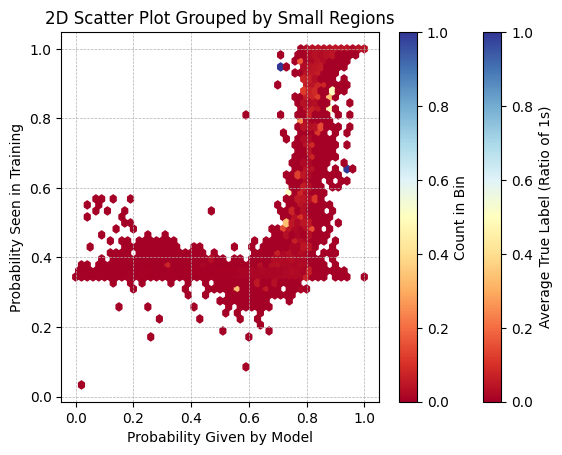

In [14]:


hb = plt.hexbin(val_probs.flatten(), ood_probs.flatten(), C=TRAFFIC_DATA['install'].values, gridsize=50, cmap='RdYlBu', reduce_C_function=np.mean)
cb = plt.colorbar(hb, label='Ratio of 1s')
cb.set_label('Average True Label (Ratio of 1s)')
plt.xlabel('Probability Given by Model')
plt.ylabel('Probability Seen in Training')
plt.title('2D Scatter Plot Grouped by Small Regions')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding an extra colorbar to represent the count in each hexbin
plt.colorbar(hb, label='Count in Bin')

plt.show()

In [20]:
class BigValuator:
  def __init__(self,valuator,valuator_ood):
    self.valuator = valuator
    self.valuator_ood = valuator_ood

  def predict(self,data):
    self.result = self.valuator.prob(data).flatten()
    self.ood_result = self.valuator_ood.prob(data).flatten()
    self.primary_predictions = self.valuator.predict(data)
    condition_met_indices = (self.result > 0.6) & (self.ood_result < stats.mode(self.ood_result).mode)
    overwrite_indices = condition_met_indices & (self.primary_predictions == 0)
    return self.result

bigval = BigValuator(valuator,valuator_ood)

In [21]:
bigval.predict(TRAFFIC_DATA)

9589/9589 [==============================] - 15s 2ms/step


array([0.6702102 , 0.61765295, 0.40958318, ..., 0.6441318 , 0.5411248 ,
       0.521351  ], dtype=float32)

In [ ]:
from scipy import stats
print(sum(bigval.primary_predictions)/len(bigval.primary_predictions))
condition_met_indices = (bigval.result > 0.6) & (bigval.ood_result < stats.mode(bigval.ood_result).mode)
overwrite_indices = condition_met_indices & (bigval.primary_predictions == 0)
bigval.primary_predictions[overwrite_indices] = 1
print(sum(bigval.primary_predictions)/len(bigval.primary_predictions))

[0.0402314]
